In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [2]:
df = pd.read_csv("data/life_expectancy.csv")
df.head()

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,HepB,measles,...,Polio,total_expenditure,DPT,HIV_AIDS,GDP,population,thinness_10_19,thinness_5_9,HDI,school_year
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [3]:
df.isna().sum()

country                     0
year                        0
status                      0
life_expectancy            10
adult_mortality            10
infant_deaths               0
alcohol                   194
percentage_expenditure      0
HepB                      553
measles                     0
BMI                        34
u5_deaths                   0
Polio                      19
total_expenditure         226
DPT                        19
HIV_AIDS                    0
GDP                       448
population                652
thinness_10_19             34
thinness_5_9               34
HDI                       167
school_year               163
dtype: int64

In [5]:
df.shape

(2938, 22)

In [7]:
# drop data target = NaN
df = df[~df.life_expectancy.isna()]
df.isna().sum()

country                     0
year                        0
status                      0
life_expectancy             0
adult_mortality             0
infant_deaths               0
alcohol                   193
percentage_expenditure      0
HepB                      553
measles                     0
BMI                        32
u5_deaths                   0
Polio                      19
total_expenditure         226
DPT                        19
HIV_AIDS                    0
GDP                       443
population                644
thinness_10_19             32
thinness_5_9               32
HDI                       160
school_year               160
dtype: int64

In [10]:
X = df.drop(columns="life_expectancy")
y = df.life_expectancy

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2342, 21), (586, 21), (2342,), (586,))

In [11]:
X_train.columns

Index(['country', 'year', 'status', 'adult_mortality', 'infant_deaths',
       'alcohol', 'percentage_expenditure', 'HepB', 'measles', 'BMI',
       'u5_deaths', 'Polio', 'total_expenditure', 'DPT', 'HIV_AIDS', 'GDP',
       'population', 'thinness_10_19', 'thinness_5_9', 'HDI', 'school_year'],
      dtype='object')

In [38]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['year', 'adult_mortality', 'infant_deaths',
       'alcohol', 'percentage_expenditure', 'HepB', 'measles', 'BMI',
       'u5_deaths', 'Polio', 'total_expenditure', 'DPT', 'HIV_AIDS', 'GDP',
       'population', 'thinness_10_19', 'thinness_5_9', 'HDI', 'school_year']),
    ('categoric', cat_pipe(encoder='onehot'), ['country', 'status']),
])

from xgboost import XGBRegressor
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])

from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__colsample_bytree': 0.42066805426927745, 'algo__gamma': 1, 'algo__learning_rate': 0.035015835937029005, 'algo__max_depth': 9, 'algo__n_estimators': 176, 'algo__reg_alpha': 2.772824182801065, 'algo__reg_lambda': 0.0010661259689433889, 'algo__subsample': 0.5553736512887829}
0.9865252262096966 0.957951869451762 0.9650497274770851


# Features importance

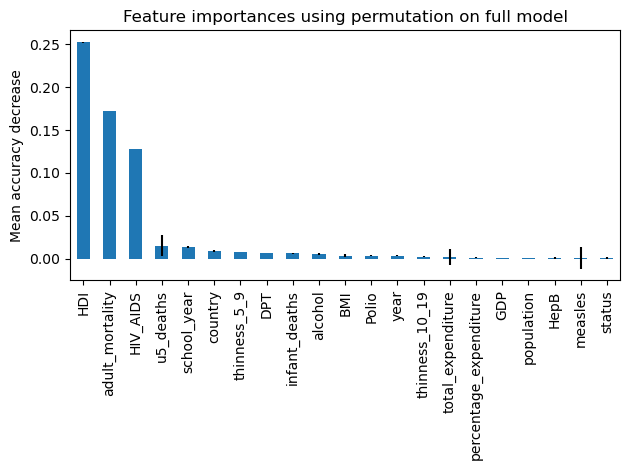

In [43]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

data_importance = pd.Series(result.importances_mean, index=['country', 'year', 'status', 'adult_mortality', 'infant_deaths',
       'alcohol', 'percentage_expenditure', 'HepB', 'measles', 'BMI',
       'u5_deaths', 'Polio', 'total_expenditure', 'DPT', 'HIV_AIDS', 'GDP',
       'population', 'thinness_10_19', 'thinness_5_9', 'HDI', 'school_year'])

fig, ax = plt.subplots()
data_importance.sort_values(ascending=False).plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [52]:
data_importance.sort_values(ascending=False)

HDI                       0.252426
adult_mortality           0.172434
HIV_AIDS                  0.128164
u5_deaths                 0.015082
school_year               0.013494
country                   0.008930
thinness_5_9              0.007979
DPT                       0.006200
infant_deaths             0.006110
alcohol                   0.005314
BMI                       0.003473
Polio                     0.003407
year                      0.003142
thinness_10_19            0.002434
total_expenditure         0.002079
percentage_expenditure    0.001206
GDP                       0.000913
population                0.000763
HepB                      0.000692
measles                   0.000650
status                    0.000633
dtype: float64

In [53]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['adult_mortality', 'infant_deaths',
       'alcohol', 'u5_deaths', 'DPT', 'HIV_AIDS', 'thinness_10_19', 'HDI', 'school_year'])
])

from xgboost import XGBRegressor
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])

from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__colsample_bytree': 0.7545447962707789, 'algo__gamma': 8, 'algo__learning_rate': 0.13832094546570484, 'algo__max_depth': 9, 'algo__n_estimators': 161, 'algo__reg_alpha': 0.02001342062287998, 'algo__reg_lambda': 0.035868164986275514, 'algo__subsample': 0.43567451588694794}
0.9923774285063562 0.9581066443437859 0.9650830827362429


# Try Polinomial

In [54]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2), ['adult_mortality', 'infant_deaths',
       'alcohol', 'u5_deaths', 'DPT', 'HIV_AIDS', 'thinness_10_19', 'HDI', 'school_year'])
])

from xgboost import XGBRegressor
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])

from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

model = RandomizedSearchCV(pipeline, rsp.xgb_poly_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__colsample_bytree': 0.6914001956501502, 'algo__gamma': 5, 'algo__learning_rate': 0.16727902653067211, 'algo__max_depth': 7, 'algo__n_estimators': 166, 'algo__reg_alpha': 0.009793184984206244, 'algo__reg_lambda': 0.02653937643936054, 'algo__subsample': 0.6789230552321847, 'prep__numeric__poly__degree': 1, 'prep__numeric__poly__interaction_only': True}
0.9946666928078463 0.956660214331342 0.9679992055551883


In [12]:
from jcopml.tuning import random_search_params as rsp

rsp.xgb_params

{'algo__max_depth': Integer(low=1, high=10),
 'algo__learning_rate': Real(low=-2, high=0, prior='log-uniform'),
 'algo__n_estimators': Integer(low=100, high=200),
 'algo__subsample': Real(low=0.3, high=0.8, prior='uniform'),
 'algo__gamma': Integer(low=1, high=10),
 'algo__colsample_bytree': Real(low=0.1, high=1, prior='uniform'),
 'algo__reg_alpha': Real(low=-3, high=1, prior='log-uniform'),
 'algo__reg_lambda': Real(low=-3, high=1, prior='log-uniform')}

In [36]:
from jcopml.tuning.space import Integer, Real

print(dir(Integer))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'rvs']


# BayesianSearchCV (Battleship)

In [56]:
from jcopml.tuning.skopt import BayesSearchCV
from jcopml.tuning import bayes_search_params as bsp
from xgboost import XGBRegressor
from skopt import BayesSearchCV


preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['adult_mortality', 'infant_deaths',
       'alcohol', 'u5_deaths', 'DPT', 'HIV_AIDS', 'thinness_10_19', 'HDI', 'school_year'])
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])

model = BayesSearchCV(pipeline, bsp.xgb_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi